In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')
from inspect import signature
from google.colab import drive
drive.mount('/content/gdrive')

# Just disables a warning, doesn't enable AVX/FMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
 print("Loading datasets...")
train = pd.read_csv("gdrive/My Drive/exoTrain.csv", encoding= "ISO-8859-1") #on data frame format
test = pd.read_csv("gdrive/My Drive/exoTest.csv", encoding= "ISO-8859-1") #on data frame format
print('loaded datasets')
x_train = train.drop('LABEL', axis=1)
x_test = test.drop('LABEL', axis=1)
y_train = train.LABEL
y_test = test.LABEL


Loading datasets...
loaded datasets


In [ ]:
type(x_train)

pandas.core.frame.DataFrame

#Visualization

In [ ]:
x_train.shape[0]


5087

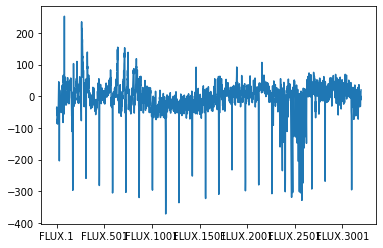

In [ ]:
x_train.iloc[1].plot()
plt.show()

##Observation:
 The data is normally distributed.

#Pre- processing

In [ ]:
x_train = np.array(x_train)

y_train = np.array(y_train).reshape((-1,1))-1
x_test = np.array(x_test)

y_test = np.array(y_test).reshape((-1,1))-1

# Add extra positive examples of light curves by flipping them
x_train = np.append(x_train, np.flip(x_train[0:37,:], axis=-1), axis=0)
y_train = np.append(y_train, y_train[0:37]).reshape((-1,1))
x_test = np.append(x_test, np.flip(x_test[0:5,:], axis=-1), axis=0)
y_test = np.append(y_test, y_test[0:5]).reshape((-1,1))
print(x_test[1])
#B = np.reshape(x_test, (-1, 3197))
#x_train = pd.Series(B)
#print(x_train)

[ 5736.59  5699.98  5717.16 ... -2366.19 -2294.86 -2034.72]


##Outlier detection

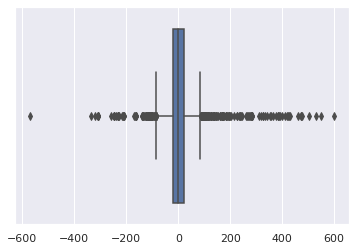

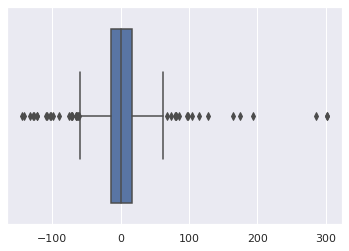

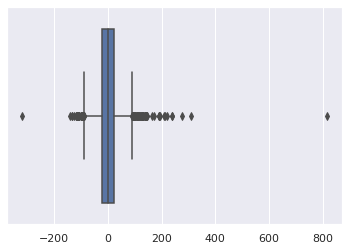

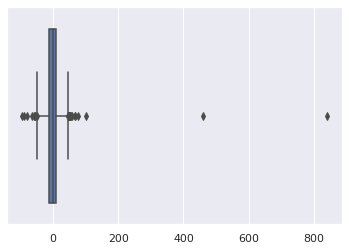

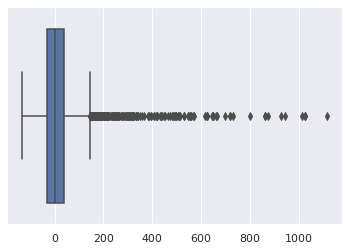

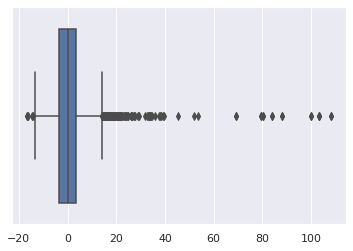

In [ ]:

nonexoplanets=[38,64,72,345,1000,2000]
for i in nonexoplanets:
  sns.set(style="darkgrid")
  plot = sns.boxplot(x_train[i])
  plt.show()



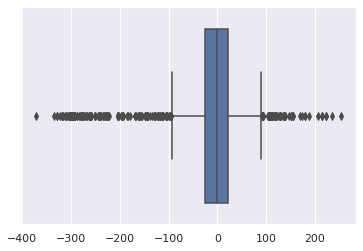

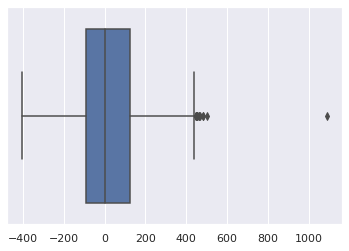

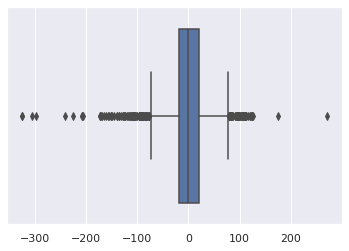

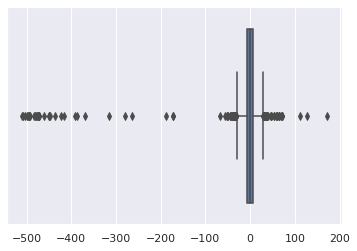

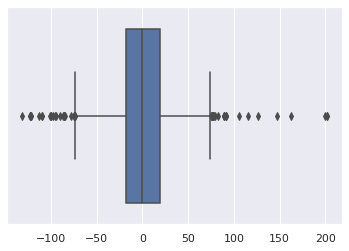

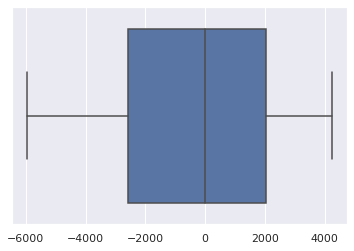

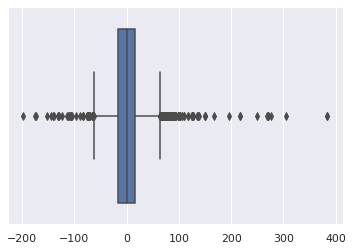

In [ ]:
exoplanets=[1,5,8,12,16,21,25]
for i in exoplanets:
  sns.set(style="darkgrid")
  plot = sns.boxplot(x_train[i])
  plt.show()


##Observation:
       The data is abundant with outliers. We should remove them.

#Hamphel Filter
   For outlier removal.

#RANDOM WALK

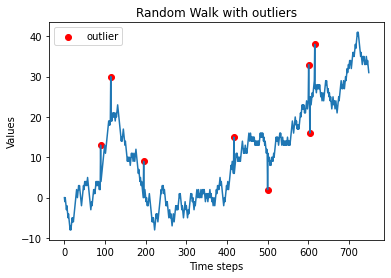

In [ ]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):

    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)

    #set seed for reproducibility
    np.random.seed(seed)

    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)

    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult

    return rw, indices
rw, outlier_ind = random_walk_with_outliers(0, 750, 0.01)
plt.plot(np.arange(len(rw)), rw)
plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

In [ ]:
def evaluate_detection(series, true_indices, detected_indices):

    # calculate metrics
    tp = list(set(detected_outliers).intersection(set(true_indices)))
    fp = list(set(detected_outliers).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_outliers)))
    perc_detected = 100 * len(tp) / len(true_indices)

    # create the plot
    fix, ax = plt.subplots(2, 1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    ax[0].plot(np.arange(len(series)), series);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
    ax[0].set_title('Original series')
    ax[0].legend()

    ax[1].plot(np.arange(len(series)), series);
    ax[1].scatter(tp, series[tp], c='g', label='true positive')
    ax[1].scatter(fp, series[fp], c='r', label='false positive')
    ax[1].scatter(fn, series[fn], c='k', label='false negative')
    ax[1].set_title('Algorithm results')
    ax[1].legend()

    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'Outliers in the series: {len(true_indices)}')
    print(f'Identified outliers: {len(detected_indices)}')
    print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)

    return tp, fp, fn

In [ ]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=4):

    n = len(input_series)
    print(n)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution

    indices = []
    print(n-window_size)
    # possibly use np.nanmedian
    for i in range((window_size),(n - window_size)):

        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if ((input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)

    return new_series, indices

In [ ]:
res, detected_outliers = hampel_filter_forloop(x_train[7], 10)

3197
3187


------------------------- Summary -------------------------
Outliers in the series: 8
Identified outliers: 44
Correctly detected outliers: 0 (0.00% of all outliers).
-----------------------------------------------------------


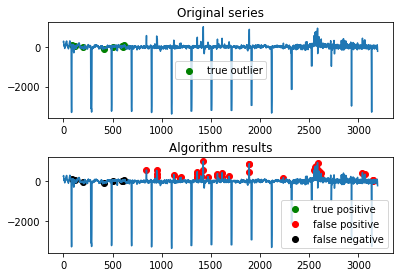

In [ ]:
tp, fp, fn = evaluate_detection(x_train[7], outlier_ind, detected_outliers)

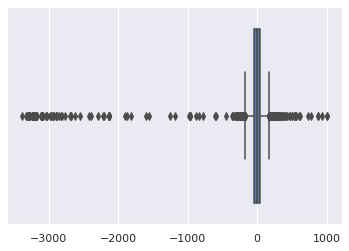

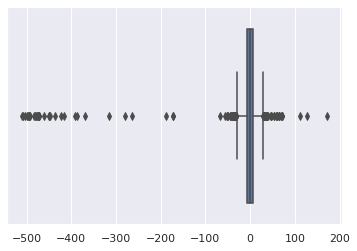

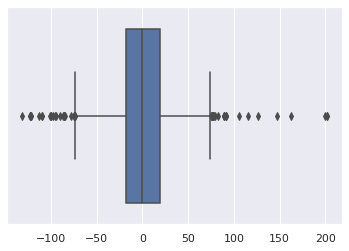

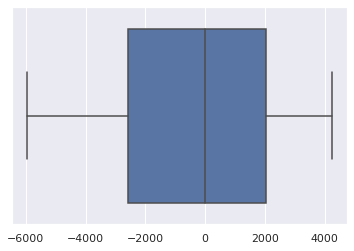

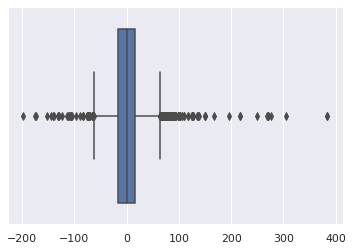

In [ ]:
exoplanets=[7,12,16,21,25]
for i in exoplanets:
  sns.set(style="darkgrid")
  plot = sns.boxplot(x_train[i])
  plt.show()


In [ ]:
import numpy as np
import pandas as pd


def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


def hampel(ts, window_size=5, n=3, imputation=True):

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeserie object must be of type pandas.Series.")

    if type(window_size) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if window_size <= 0:
            raise ValueError("Window size must be more than 0.")

    if type(n) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if n < 0:
            raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeseries
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    k = 1.4826

    rolling_ts = ts_cleaned.rolling(window_size*2, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_sigma = k*(rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outlier_indices = list(
        np.array(np.where((ts_cleaned - rolling_median) >= (n * rolling_sigma))).flatten())

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices

In [ ]:
x_train.iloc[0]
#x_train[7]


FLUX.1       93.85
FLUX.2       83.81
FLUX.3       20.10
FLUX.4      -26.98
FLUX.5      -39.56
             ...  
FLUX.3193    92.54
FLUX.3194    39.32
FLUX.3195    61.42
FLUX.3196     5.08
FLUX.3197   -39.54
Name: 0, Length: 3197, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#for i in range(x_train.shape[0]):
  #ts= x_train.iloc[i]
  # Just outlier detection
  #outlier_indices = hampel(ts, window_size=5, n=3)
#print("Outlier Indices: ", outlier_indices)

  # Outlier Imputation with rolling median
 # ts_imputation = hampel(ts, window_size=10, n=3, imputation=True)


def loop_impl(x_train):

  result = []
  coi=0
  for i in range(10):
    coi+=1
    print(coi)
    row = x_train.iloc[i]
    #outlier_indices = hampel(ts, window_size=5, n=3)
    result.append(hampel(row, window_size=10, n=3, imputation=True))
  return pd.Series(result)


In [ ]:
x_trainnew = loop_impl(x_train)

1
2
3
4
5
6
7
8
9
10


In [ ]:
x_trainnew.iloc[0]

FLUX.1       93.85
FLUX.2       83.81
FLUX.3       20.10
FLUX.4      -26.98
FLUX.5      -39.56
             ...  
FLUX.3193    92.54
FLUX.3194    39.32
FLUX.3195    61.42
FLUX.3196     5.08
FLUX.3197   -39.54
Name: 0, Length: 3197, dtype: float64

In [ ]:
x_trainnew.iloc[1]

FLUX.1      -38.88
FLUX.2      -33.83
FLUX.3      -58.54
FLUX.4      -40.09
FLUX.5      -79.31
             ...  
FLUX.3193     0.76
FLUX.3194   -11.70
FLUX.3195     6.46
FLUX.3196    16.00
FLUX.3197    19.93
Name: 1, Length: 3197, dtype: float64

In [ ]:
x_trainnew.iloc[2]

FLUX.1       532.64
FLUX.2       535.92
FLUX.3       513.73
FLUX.4       496.92
FLUX.5       456.45
              ...  
FLUX.3193      5.06
FLUX.3194    -11.80
FLUX.3195    -28.91
FLUX.3196    -70.02
FLUX.3197    -96.67
Name: 2, Length: 3197, dtype: float64

In [ ]:
x_trainnew.iloc[7]

FLUX.1       238.77
FLUX.2       262.16
FLUX.3       277.80
FLUX.4       190.16
FLUX.5       180.98
              ...  
FLUX.3193     95.30
FLUX.3194     48.86
FLUX.3195    -10.62
FLUX.3196   -112.02
FLUX.3197   -229.92
Name: 7, Length: 3197, dtype: float64

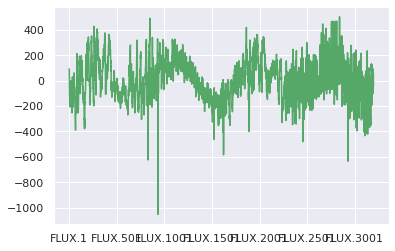

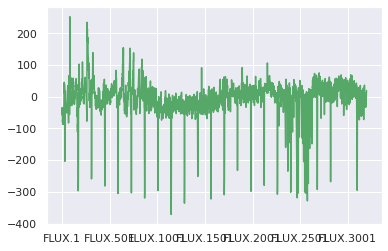

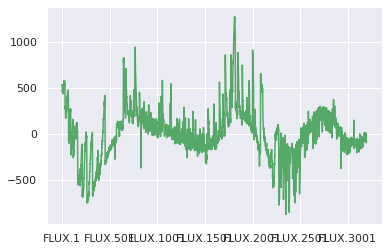

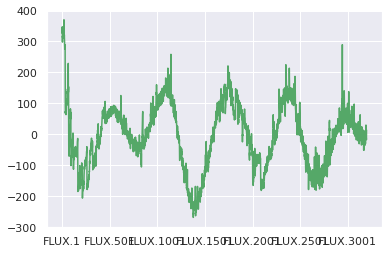

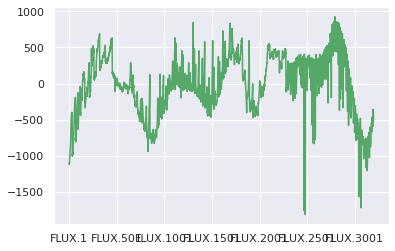

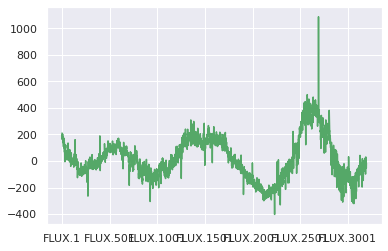

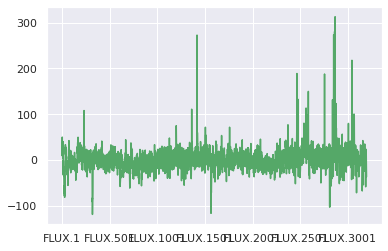

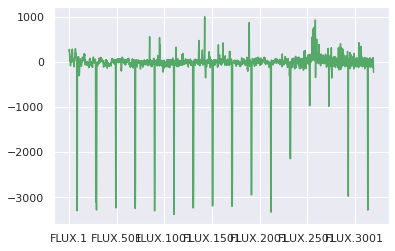

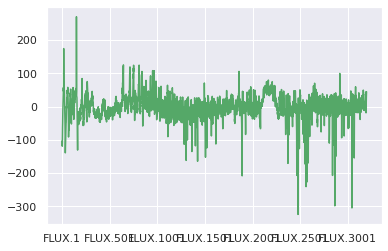

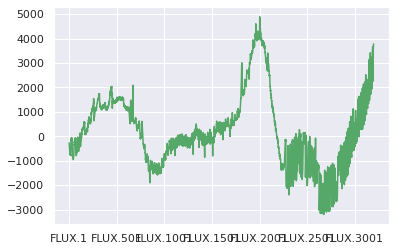

In [ ]:
for i in range(10):
  t=x_train.iloc[i]
  t.plot(style="g-")
  plt.show()